# 07c_physical_variables_analysis (Guadalajara only)

This notebook __analyses the variables__ located in edges for the __entire city (Guadalajara) and its polys__ (Colinas, Miramar, Providencia).

* Statistical measurements (min, mean, median, std, max)
* Scatterplots
* Correlations

## Import libraries

In [1]:
first_folder_path = '../../../'

In [2]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
import random
import scipy.stats as stats

import os
import sys
module_path = os.path.abspath(os.path.join(first_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Notebook config

In [3]:
# ----- ----- ----- Projection to be used when needed ----- ----- -----
projected_crs = "EPSG:32613"

## Load data

In [4]:
edges_var_final = gpd.read_file(first_folder_path + "data/processed/volvo/edges_var_gdl/edges_var_gdl.gpkg")

# Show
print(edges_var_final.crs)
print(edges_var_final.shape)
edges_var_final.head(2)

EPSG:32613
(197439, 20)


,u,v,key,grade_abs,ndvi_mean,entropy,sidewalk_available,no_sidewalk_available,banqueta_pct,pobtot_u,pobtot_v,total_pobtot,average_population,dens_u,dens_v,average_density,interdens_u,interdens_v,average_intersdens,geometry
0,67637870229114485,67640019229114922,0,0.0,0.118923,1.144632,179.791185,69.176583,0.722146,80.0,27.0,107.0,53.5,153.566318,111.104363,132.335341,19.498764,19.071526,19.285145,"MULTILINESTRING ((676378.709 2291144.858, 6763..."
1,67640019229114922,67640526229117504,0,0.0,0.188798,0.317370,181.014513,68.547498,0.725329,27.0,5.0,32.0,16.0,111.104363,31.101049,71.102706,19.071526,19.041632,19.056579,"MULTILINESTRING ((676400.196 2291149.223, 6764..."


In [5]:
gdl_polys = gpd.read_file(first_folder_path + "data/processed/volvo/polys_gdl/Poligonos.gpkg")

# Show
print(gdl_polys.crs)
print(gdl_polys.shape)
gdl_polys

EPSG:32613
(3, 2)


,name,geometry
0,miramar,"POLYGON ((659404.786 2283009.827, 660250.98 22..."
1,providencia,"POLYGON ((668619.092 2288755.457, 668816.754 2..."
2,colinas,"POLYGON ((665060.447 2289080.643, 665057.51 22..."


## Data analysis

In [6]:
vars_of_interest = ['grade_abs','ndvi_mean','entropy','banqueta_pct','average_population','average_density','average_intersdens']

edges_var_city = edges_var_final[['u','v','key']+vars_of_interest+['geometry']].copy()

# Show
print(edges_var_city.shape)
edges_var_city.head(2)

(197439, 11)


,u,v,key,grade_abs,ndvi_mean,entropy,banqueta_pct,average_population,average_density,average_intersdens,geometry
0,67637870229114485,67640019229114922,0,0.0,0.118923,1.144632,0.722146,53.5,132.335341,19.285145,"MULTILINESTRING ((676378.709 2291144.858, 6763..."
1,67640019229114922,67640526229117504,0,0.0,0.188798,0.317370,0.725329,16.0,71.102706,19.056579,"MULTILINESTRING ((676400.196 2291149.223, 6764..."


<Axes: >

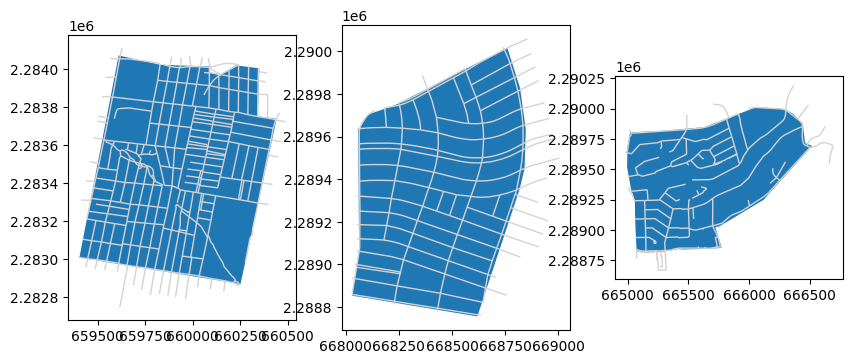

In [7]:
# Sjoin data
# Miramar's data
edges_var_miramar = gpd.sjoin(edges_var_city,gdl_polys.loc[gdl_polys.name=='miramar'].copy())
# Providencia's data
edges_var_providencia = gpd.sjoin(edges_var_city,gdl_polys.loc[gdl_polys.name=='providencia'].copy())
# Colinas's data
edges_var_colinas = gpd.sjoin(edges_var_city,gdl_polys.loc[gdl_polys.name=='colinas'].copy())

# Plot
fig,axs=plt.subplots(1,3,figsize=(10,30))
# Plot Miramar
edges_var_miramar.plot(ax=axs[0],zorder=1,color='lightgrey',linewidth=1)
gdl_polys.loc[gdl_polys.name=='miramar'].plot(ax=axs[0],zorder=0)
# Plot Providencia
edges_var_providencia.plot(ax=axs[1],zorder=1,color='lightgrey',linewidth=1)
gdl_polys.loc[gdl_polys.name=='providencia'].plot(ax=axs[1],zorder=0)
# Plot Colinas
edges_var_colinas.plot(ax=axs[2],zorder=1,color='lightgrey',linewidth=1)
gdl_polys.loc[gdl_polys.name=='colinas'].plot(ax=axs[2],zorder=0)

### Miramar

In [8]:
miramar_stats = edges_var_miramar[vars_of_interest].agg(['min', 'mean', 'median', 'std', 'max'])
miramar_stats

,grade_abs,ndvi_mean,entropy,banqueta_pct,average_population,average_density,average_intersdens
min,0.000000,0.039991,0.000000,0.000470,3.500000,3.448685,9.228745
mean,0.027657,0.122659,0.783056,0.614163,68.043046,188.046842,36.505616
median,0.018531,0.097120,0.822580,0.664861,62.500000,199.041207,37.845240
std,0.046856,0.067661,0.470561,0.329935,36.074419,74.729631,6.443570
max,0.436252,0.413015,2.034625,1.000000,189.000000,388.534848,44.922808


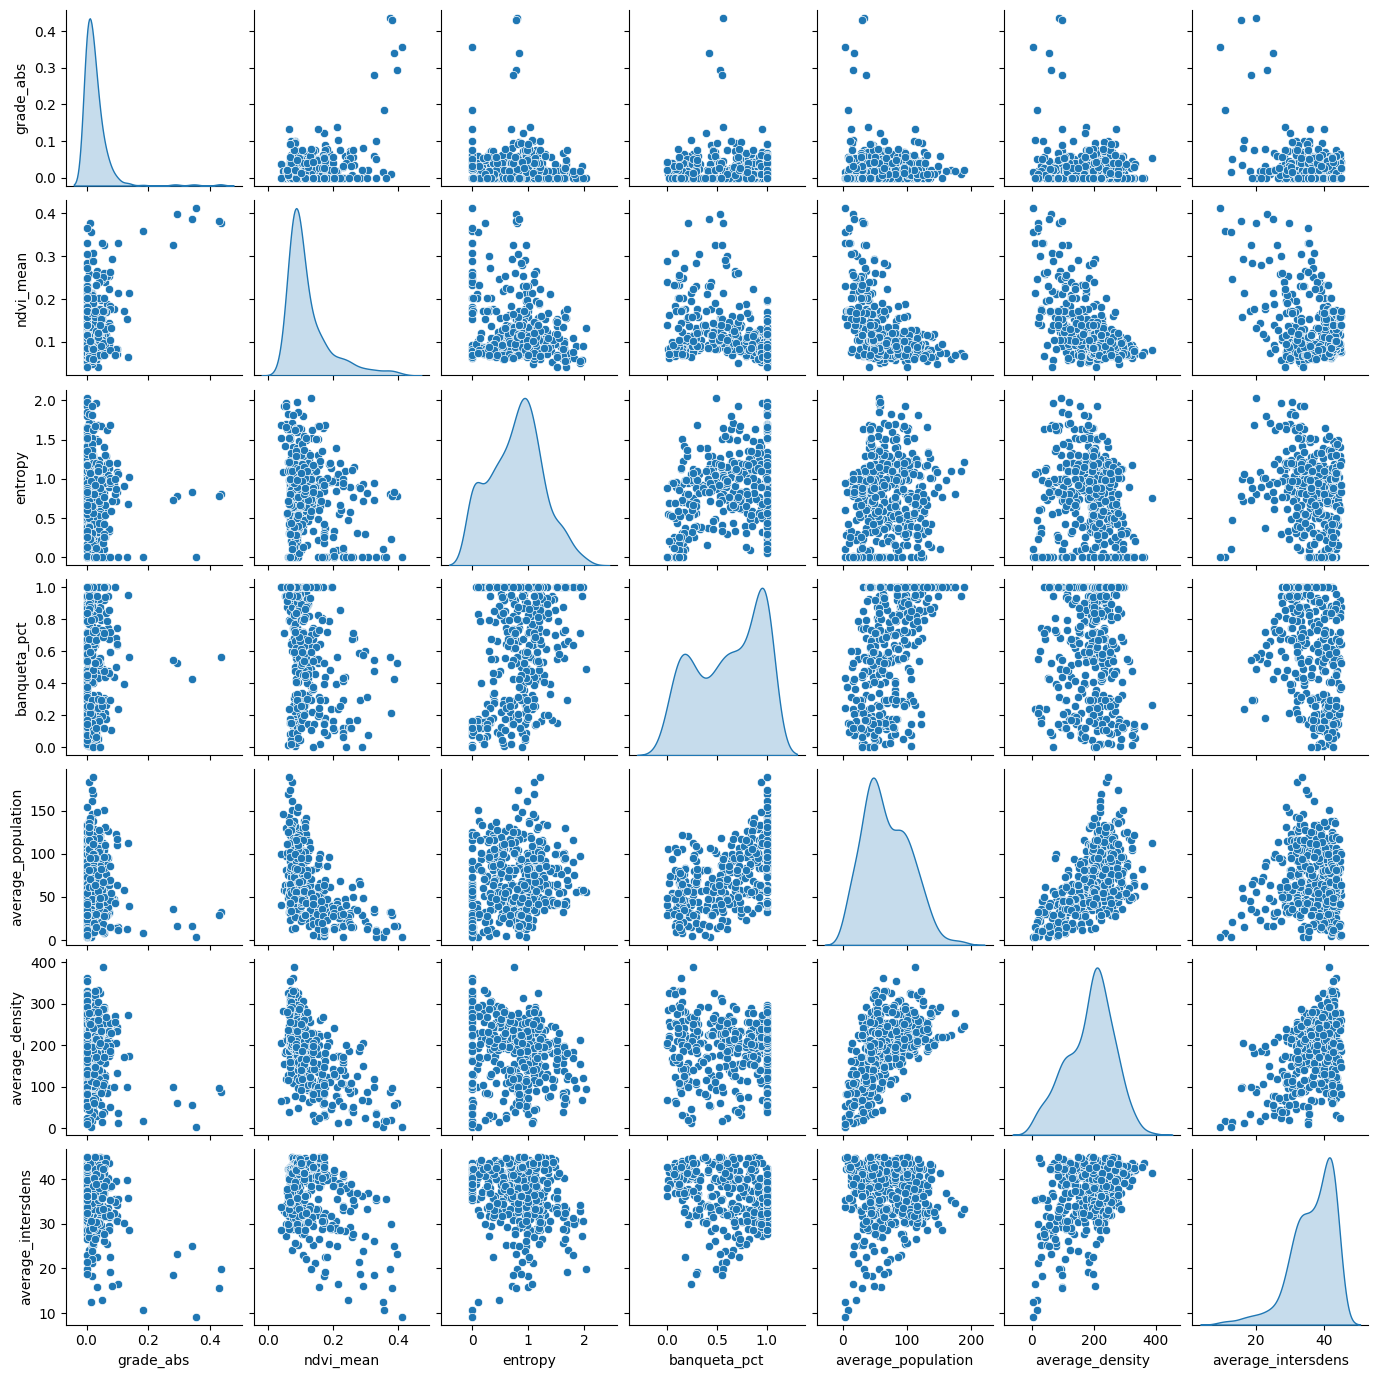

In [9]:
sns.pairplot(edges_var_miramar[vars_of_interest], diag_kind='kde', height=2);

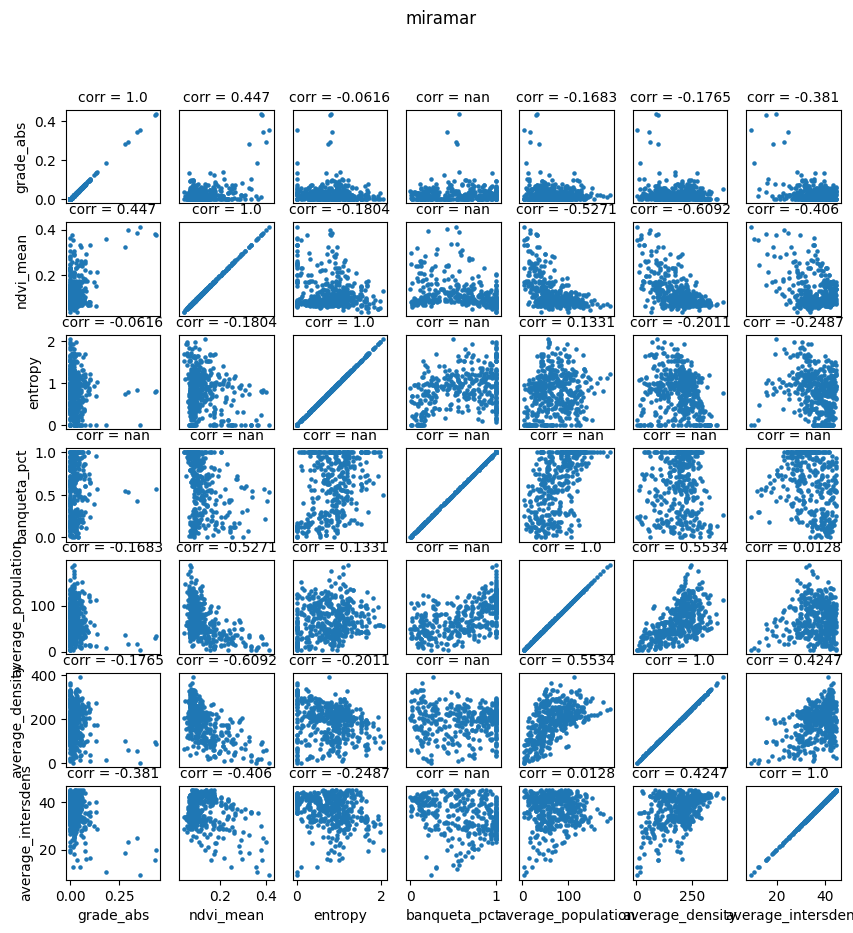

In [10]:
gdf_name = 'miramar'
gdf = edges_var_miramar.copy()
cols = vars_of_interest.copy()

# Crear grid de subplots igual al número de posibilidades de variables (4 columnas, combinadas entre sí = 4x4)
fig, axs = plt.subplots(len(cols), len(cols), figsize=(10,10))
fig.suptitle(gdf_name)

# Iterar entre las columnas
for i in range(len(cols)):
    for j in range(len(cols)):
        #Plot
        axs[i,j].scatter(gdf[cols[j]], gdf[cols[i]], s=5)

        #Correlación
        corr, pval = stats.pearsonr(gdf[cols[j]],gdf[cols[i]])
        axs[i,j].set_title("corr = {}".format(round(corr, 4)),fontsize=10)

        # Formato - apagar las tick marks
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)

        # Formato - prender las ticks de la última línea
        if i == len(cols) - 1:
            axs[i,j].get_xaxis().set_visible(True)
            axs[i,j].set_xlabel(cols[j])

        if j == 0:
            axs[i,j].get_yaxis().set_visible(True)
            axs[i,j].set_ylabel(cols[i])

### Providencia

In [11]:
providencia_stats = edges_var_providencia[vars_of_interest].agg(['min', 'mean', 'median', 'std', 'max'])
providencia_stats

,grade_abs,ndvi_mean,entropy,banqueta_pct,average_population,average_density,average_intersdens
min,0.000000,0.081683,0.000000,0.572219,6.500000,12.552212,12.210124
mean,0.021568,0.181357,0.702763,0.974389,48.227273,53.205522,16.141149
median,0.015881,0.172367,0.748966,1.000000,48.000000,49.957814,16.047789
std,0.018611,0.050411,0.505905,0.082948,22.544471,19.494808,1.582856
max,0.090091,0.333448,1.811109,1.000000,112.500000,98.081718,19.366620


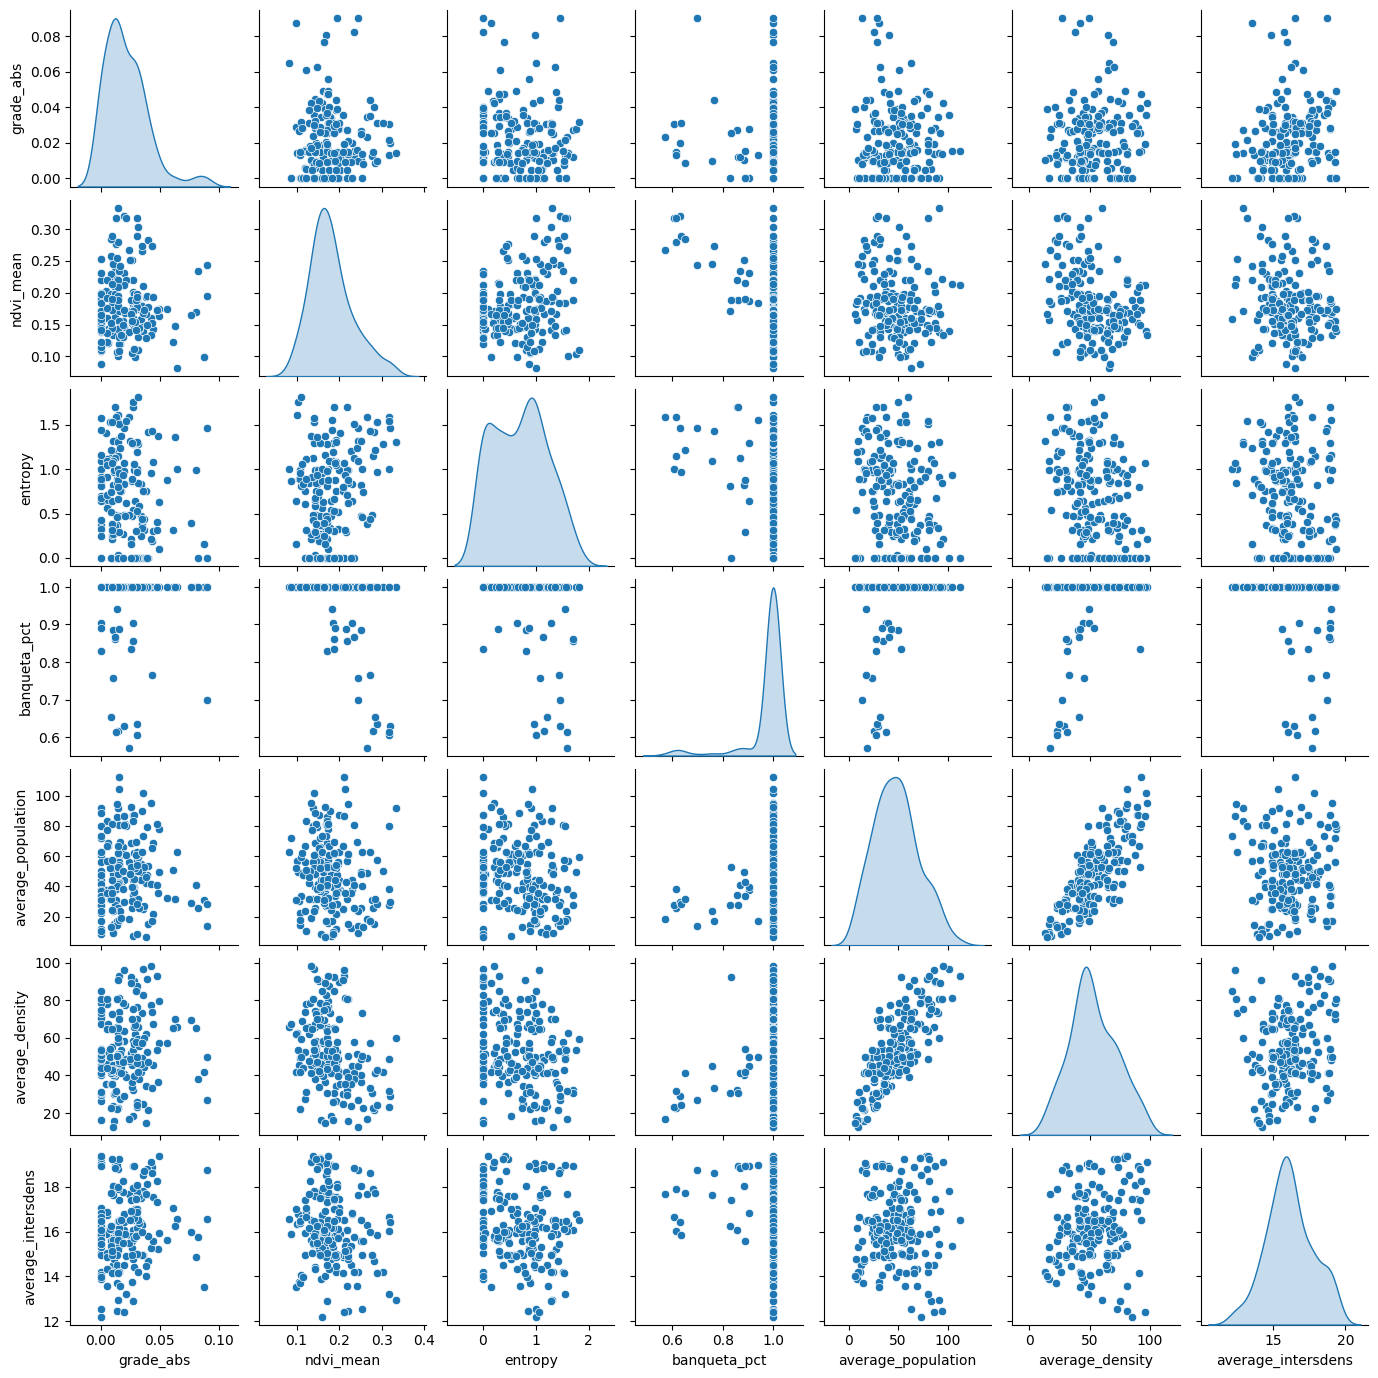

In [12]:
sns.pairplot(edges_var_providencia[vars_of_interest], diag_kind='kde', height=2);

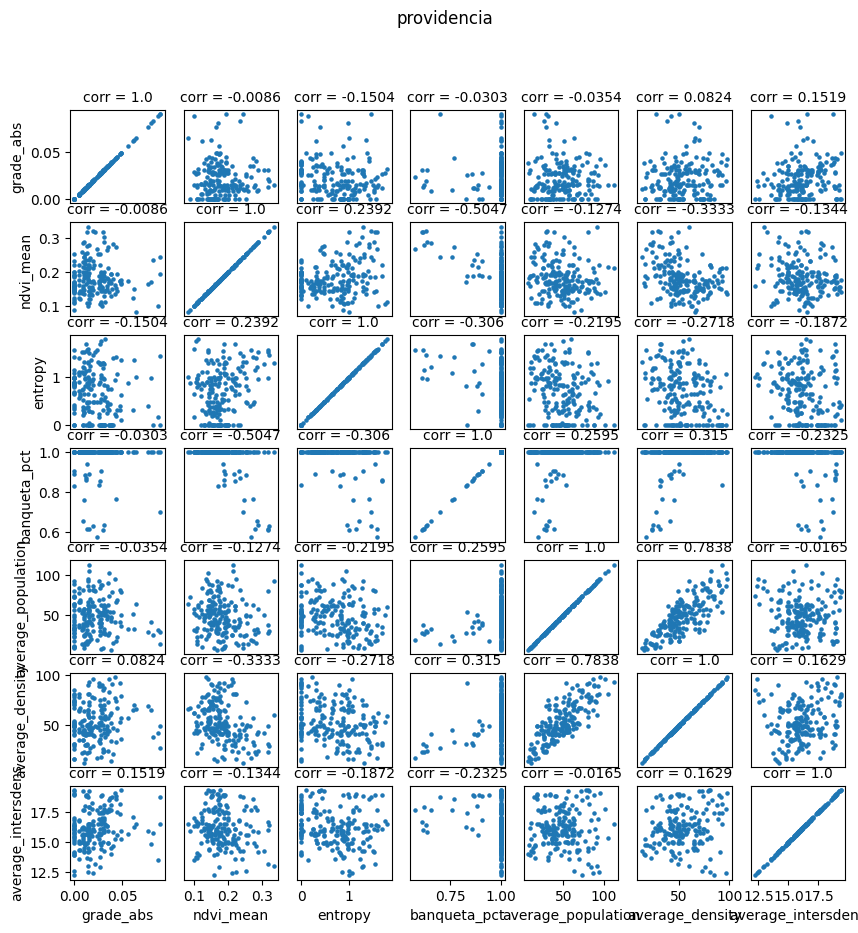

In [13]:
gdf_name = 'providencia'
gdf = edges_var_providencia.copy()
cols = vars_of_interest.copy()

# Crear grid de subplots igual al número de posibilidades de variables (4 columnas, combinadas entre sí = 4x4)
fig, axs = plt.subplots(len(cols), len(cols), figsize=(10,10))
fig.suptitle(gdf_name)

# Iterar entre las columnas
for i in range(len(cols)):
    for j in range(len(cols)):
        #Plot
        axs[i,j].scatter(gdf[cols[j]], gdf[cols[i]], s=5)

        #Correlación
        corr, pval = stats.pearsonr(gdf[cols[j]],gdf[cols[i]])
        axs[i,j].set_title("corr = {}".format(round(corr, 4)),fontsize=10)

        # Formato - apagar las tick marks
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)

        # Formato - prender las ticks de la última línea
        if i == len(cols) - 1:
            axs[i,j].get_xaxis().set_visible(True)
            axs[i,j].set_xlabel(cols[j])

        if j == 0:
            axs[i,j].get_yaxis().set_visible(True)
            axs[i,j].set_ylabel(cols[i])

### Colinas

In [14]:
stats_colinas = edges_var_colinas[vars_of_interest].agg(['min', 'mean', 'median', 'std', 'max'])
stats_colinas

,grade_abs,ndvi_mean,entropy,banqueta_pct,average_population,average_density,average_intersdens
min,0.000000,0.070708,0.000000,0.096604,1.500000,8.899083,0.389412
mean,0.027230,0.235679,0.544465,0.896247,47.489362,38.094291,7.287673
median,0.018986,0.233714,0.575478,1.000000,42.500000,36.570016,7.072512
std,0.030448,0.078902,0.380601,0.217495,28.516441,16.322432,2.817643
max,0.160748,0.484333,1.771917,1.000000,134.500000,79.533131,13.736239


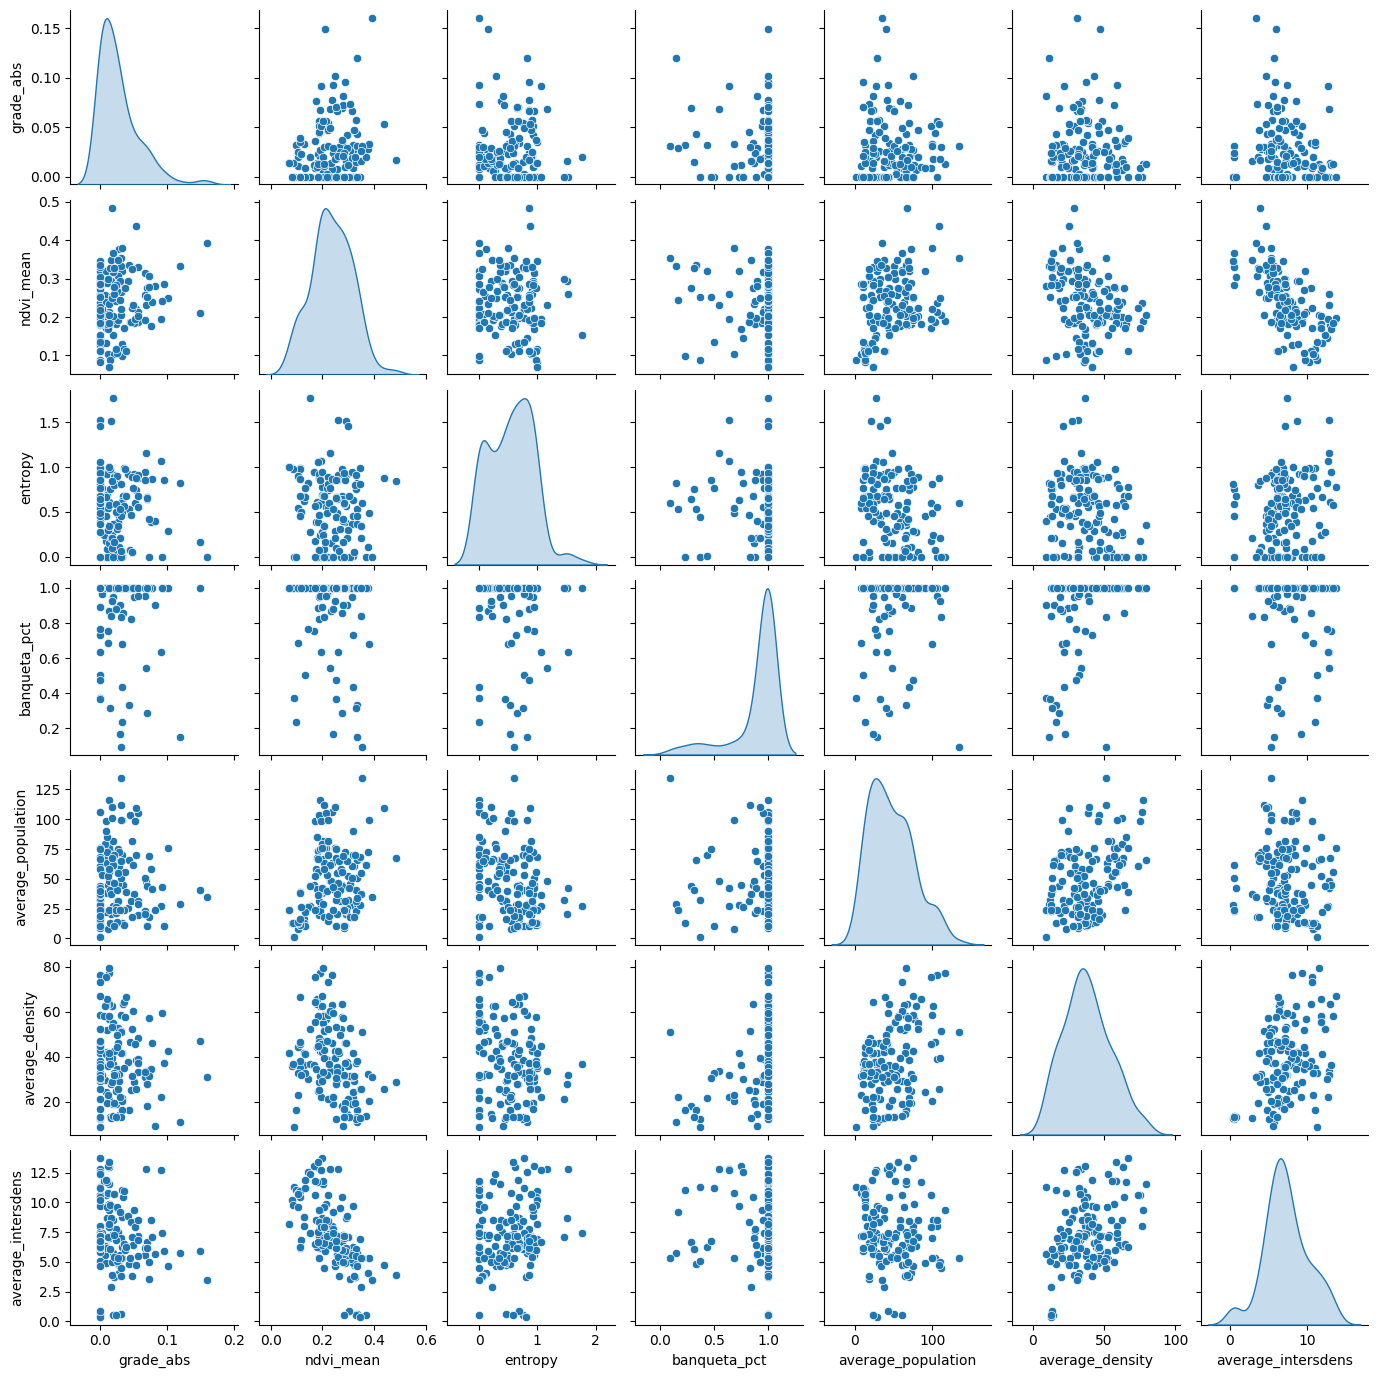

In [15]:
sns.pairplot(edges_var_colinas[vars_of_interest], diag_kind='kde', height=2);

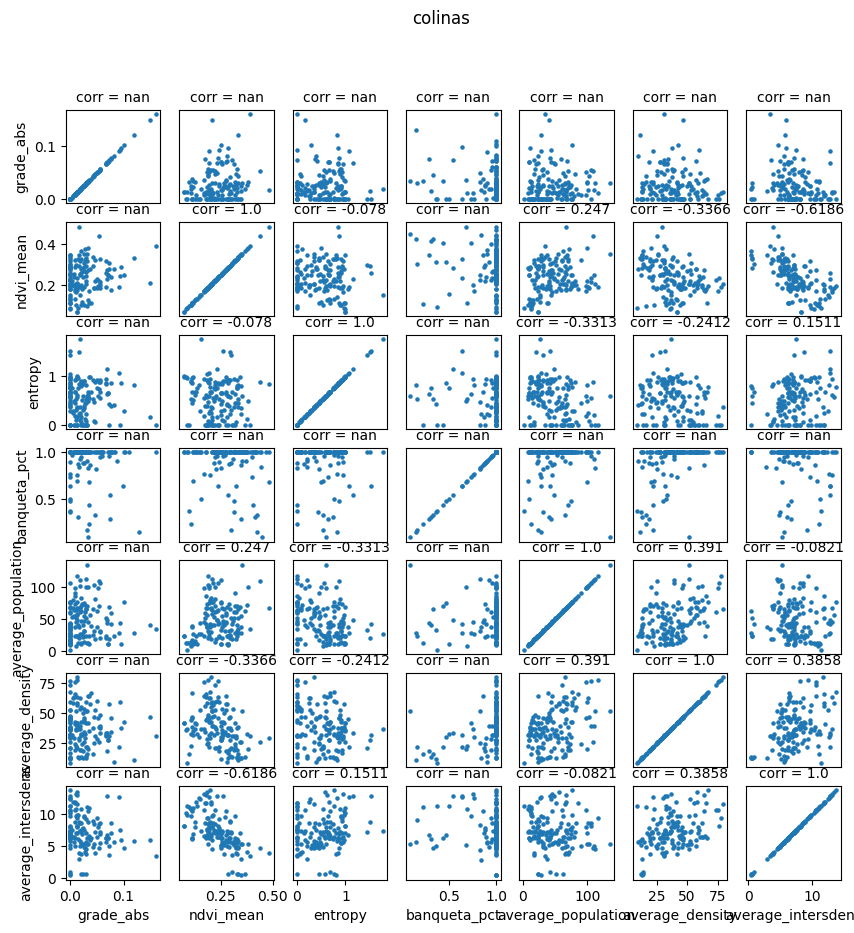

In [16]:
gdf_name = 'colinas'
gdf = edges_var_colinas.copy()
cols = vars_of_interest.copy()

# Crear grid de subplots igual al número de posibilidades de variables (4 columnas, combinadas entre sí = 4x4)
fig, axs = plt.subplots(len(cols), len(cols), figsize=(10,10))
fig.suptitle(gdf_name)

# Iterar entre las columnas
for i in range(len(cols)):
    for j in range(len(cols)):
        #Plot
        axs[i,j].scatter(gdf[cols[j]], gdf[cols[i]], s=5)

        #Correlación
        corr, pval = stats.pearsonr(gdf[cols[j]],gdf[cols[i]])
        axs[i,j].set_title("corr = {}".format(round(corr, 4)),fontsize=10)

        # Formato - apagar las tick marks
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)

        # Formato - prender las ticks de la última línea
        if i == len(cols) - 1:
            axs[i,j].get_xaxis().set_visible(True)
            axs[i,j].set_xlabel(cols[j])

        if j == 0:
            axs[i,j].get_yaxis().set_visible(True)
            axs[i,j].set_ylabel(cols[i])

### Guadalajara

In [17]:
stats_gdl = edges_var_city[vars_of_interest].agg(['min', 'mean', 'median', 'std', 'max'])
stats_gdl

,grade_abs,ndvi_mean,entropy,banqueta_pct,average_population,average_density,average_intersdens
min,0.000000,-0.101853,0.000000,0.000007,0.000000,0.000000,0.001097
mean,0.025029,0.167639,0.776128,0.773379,44.043566,102.067957,26.756802
median,0.014573,0.152691,0.832477,0.913471,35.000000,86.897447,25.126199
std,0.037738,0.088338,0.519273,0.284620,41.140570,87.337556,13.785690
max,1.435895,0.669174,2.515576,1.000000,3246.500000,2283.943453,135.442268


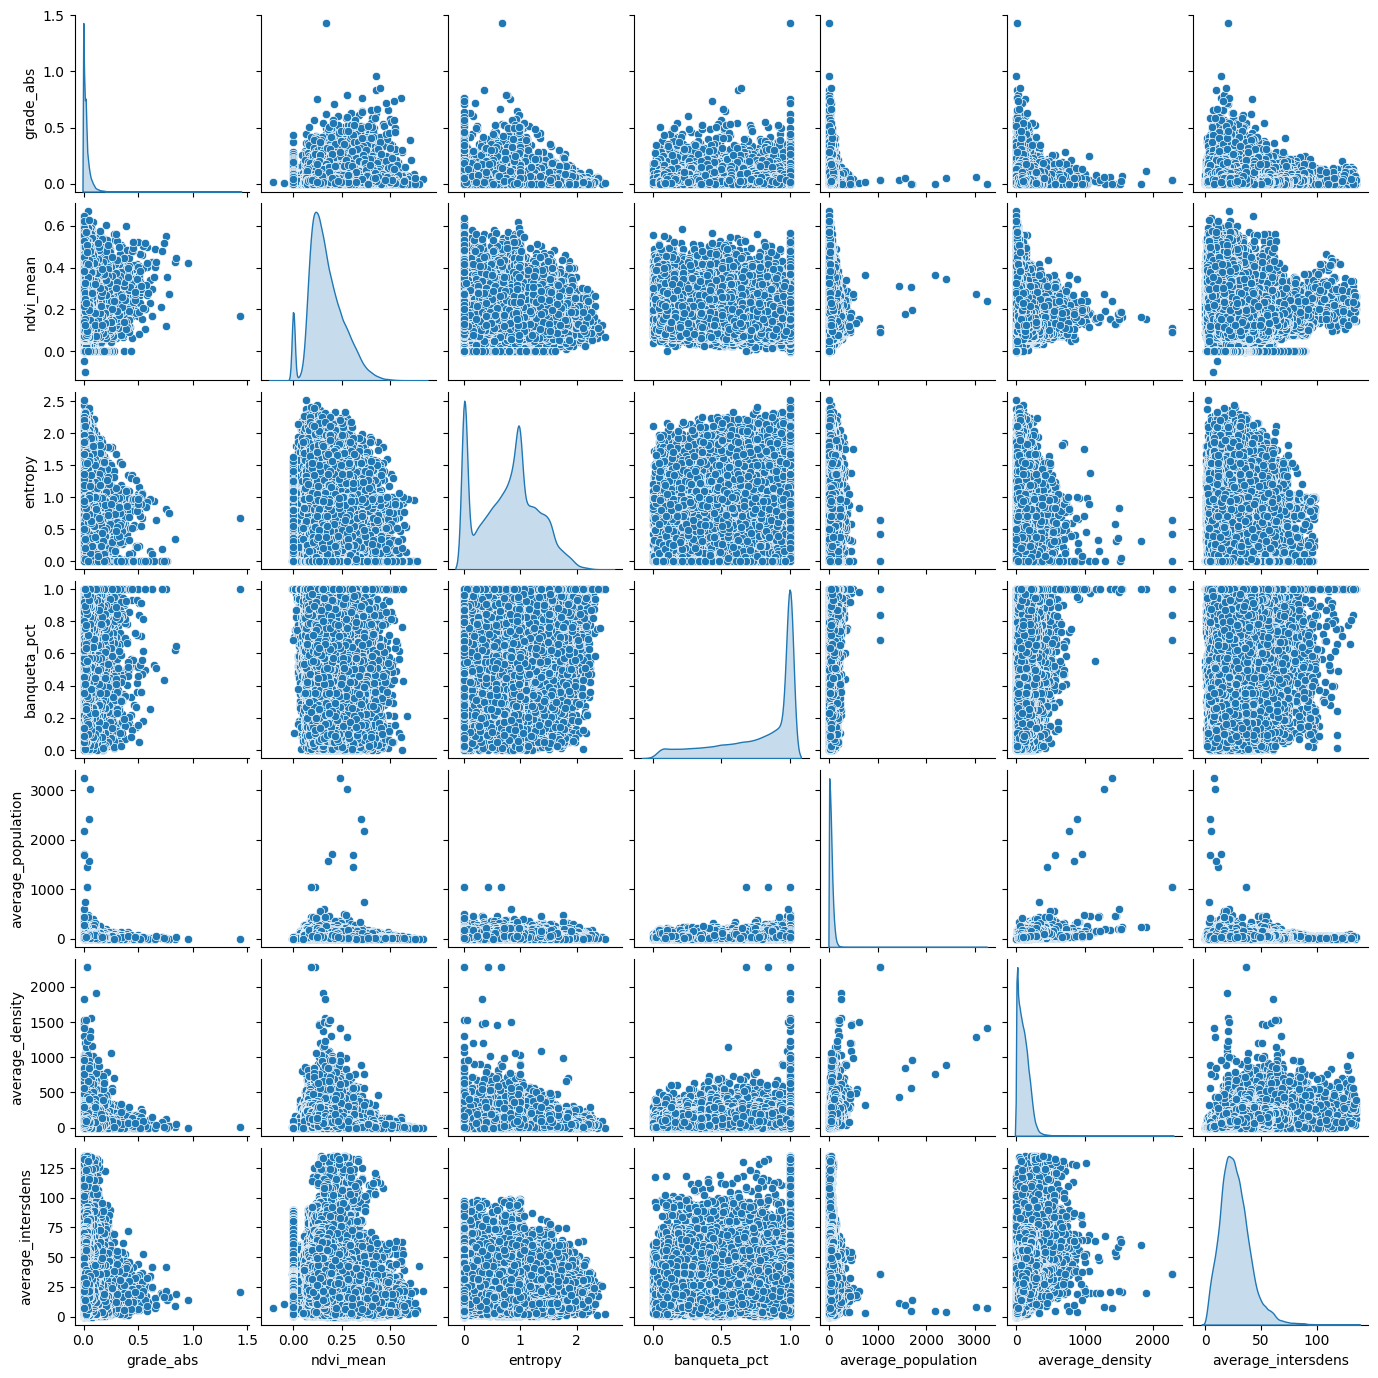

In [18]:
sns.pairplot(edges_var_city[vars_of_interest], diag_kind='kde', height=2);

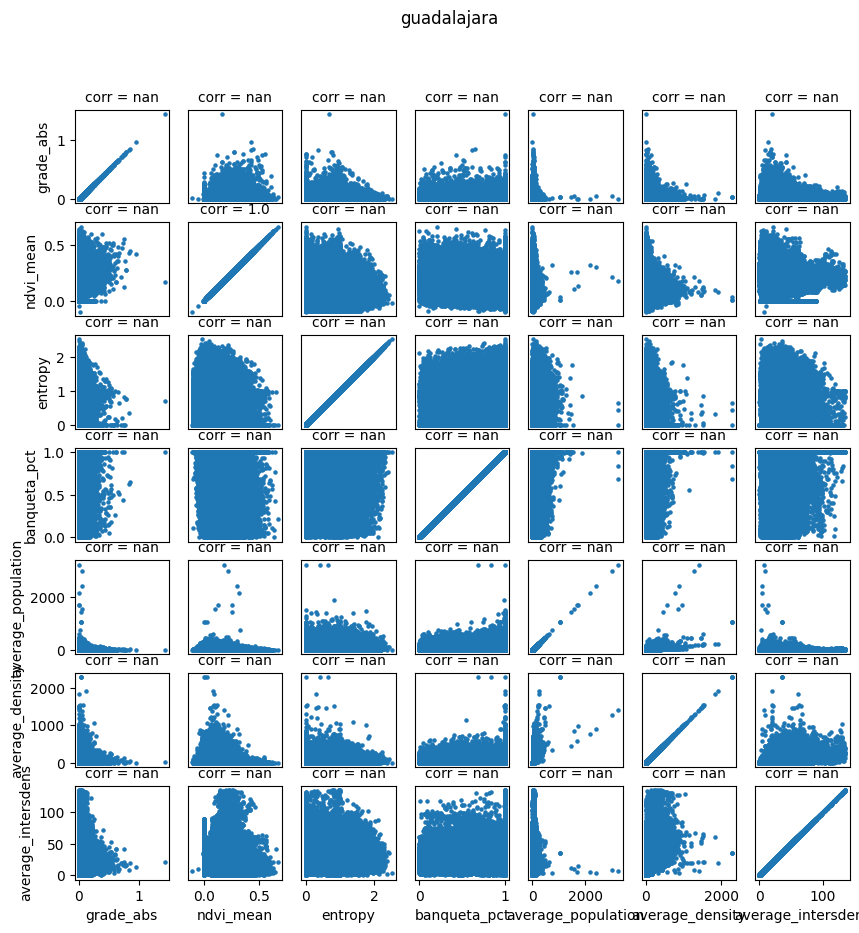

In [19]:
gdf_name = 'guadalajara'
gdf = edges_var_city.copy()
cols = vars_of_interest.copy()

# Crear grid de subplots igual al número de posibilidades de variables (4 columnas, combinadas entre sí = 4x4)
fig, axs = plt.subplots(len(cols), len(cols), figsize=(10,10))
fig.suptitle(gdf_name)

# Iterar entre las columnas
for i in range(len(cols)):
    for j in range(len(cols)):
        #Plot
        axs[i,j].scatter(gdf[cols[j]], gdf[cols[i]], s=5)

        #Correlación
        corr, pval = stats.pearsonr(gdf[cols[j]],gdf[cols[i]])
        axs[i,j].set_title("corr = {}".format(round(corr, 4)),fontsize=10)

        # Formato - apagar las tick marks
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)

        # Formato - prender las ticks de la última línea
        if i == len(cols) - 1:
            axs[i,j].get_xaxis().set_visible(True)
            axs[i,j].set_xlabel(cols[j])

        if j == 0:
            axs[i,j].get_yaxis().set_visible(True)
            axs[i,j].set_ylabel(cols[i])